In [1]:
# If using CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = ('cpu')

In [1]:
# If using GPU
# device = ('cuda')

In [2]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# CIFAR 100
training_dataset = torchvision.datasets.CIFAR100(root='datasets',download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR100(root='datasets',download=True, train=False)
# x_train = training_dataset.data
# x_train = torch.Tensor(training_dataset.data)
x_train = torch.Tensor(training_dataset.data).permute(0, 3, 1, 2)
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
# x_test = testing_dataset.data
# x_test = torch.Tensor(testing_dataset.data)
x_test = torch.Tensor(testing_dataset.data).permute(0, 3, 1 ,2)
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)
print(x_train.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [14]:
# MNIST
training_dataset = torchvision.datasets.MNIST(root='datasets',download=True, train=True)
testing_dataset = torchvision.datasets.MNIST(root='datasets',download=True, train=False)
# x_train = training_dataset.data.unsqueeze(3).repeat(1,1,1,3)
x_train = training_dataset.data.unsqueeze(1).repeat(1,3,1,1)
y_train = training_dataset.targets
# x_test = testing_dataset.data.unsqueeze(3).repeat(1,1,1,3)
x_test = testing_dataset.data.unsqueeze(1).repeat(1,3,1,1)
y_test = testing_dataset.targets
print(x_train.shape)
print(x_test.shape)

torch.Size([60000, 28, 28, 3])
torch.Size([10000, 28, 28, 3])


In [4]:
split_point = int(x_train.shape[0] * 0.8)
split_point

In [7]:
batch_size = 250
xy_train = torch.utils.data.DataLoader(list(zip(x_train[:split_point],
                                                y_train[:split_point])),
                                       shuffle=True, batch_size=batch_size,
                                       num_workers=8)
xy_val = torch.utils.data.DataLoader(list(zip(x_train[split_point:],
                                              y_train[split_point:])),
                                     shuffle=False, batch_size=batch_size,
                                     num_workers=8)
xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                       shuffle=False, batch_size=batch_size,
                                      num_workers=8)

In [8]:
class ResidualBlock(torch.nn.Module):
    def __init__(self,
                 hidden_size = 256,
                 **kwargs):
        super().__init__(**kwargs)
        self.residual = torch.nn.Sequential(*[
            torch.nn.ZeroPad2d((1,1,1,1)),
            torch.nn.Conv2d(hidden_size,
                            hidden_size,
                            (3,3)),
            torch.nn.BatchNorm2d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.1),
        ])
                     
    def forward(self, y):
        return y + self.residual(y) # Note addition (skip)

In [17]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self,
                 input_shape,
                 output_size,
                 hidden_size = 256,
                 num_hidden_layers = 6,
                 **kwargs):
        super().__init__(**kwargs)

        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])

        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])

        input_shape = np.array(input_shape,dtype=int)
        layer_list = []

        # Initial Linear Projection
        layer_list.append(
            torch.nn.Conv2d(input_shape[0],
                            hidden_size,
                            (1,1)))

        for i in range(num_hidden_layers):
            layer_list.append(ResidualBlock(hidden_size))
            if i % 2 == 1:
                layer_list.append(torch.nn.MaxPool2d((2,2)))
                input_shape[1:] //= 2
    
        layer_list.append(
            torch.nn.Flatten())

        self.hidden_layers = torch.nn.Sequential(*layer_list)
        self.output_layer = torch.nn.Linear(input_shape[1:].prod()*hidden_size,
                                            output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)
        y = self.hidden_layers(y)
        y = self.output_layer(y)       
        return y

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

In [18]:
model = NeuralNetwork(x_train.shape[1:],
                      len(torch.unique(y_train)))

print(model)

NeuralNetwork(
  (hidden_layers): Sequential(
    (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ResidualBlock(
      (residual): Sequential(
        (0): ZeroPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Dropout2d(p=0.1, inplace=False)
      )
    )
    (2): ResidualBlock(
      (residual): Sequential(
        (0): ZeroPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Dropout2d(p=0.1, inplace=False)
      )
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (residual): Sequential(
        (0): ZeroPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), st

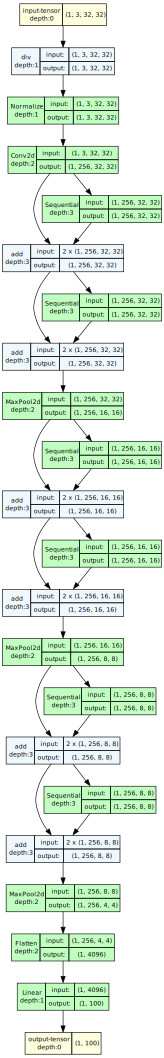

In [19]:
model_graph = draw_graph(model, input_data=x_train[0:1], device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=3)
model_graph.visual_graph

In [20]:
summary(model, input_size=(1,)+x_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 100]                  --
├─Sequential: 1-1                        [1, 4096]                 --
│    └─Conv2d: 2-1                       [1, 256, 32, 32]          1,024
│    └─ResidualBlock: 2-2                [1, 256, 32, 32]          --
│    │    └─Sequential: 3-1              [1, 256, 32, 32]          590,592
│    └─ResidualBlock: 2-3                [1, 256, 32, 32]          --
│    │    └─Sequential: 3-2              [1, 256, 32, 32]          590,592
│    └─MaxPool2d: 2-4                    [1, 256, 16, 16]          --
│    └─ResidualBlock: 2-5                [1, 256, 16, 16]          --
│    │    └─Sequential: 3-3              [1, 256, 16, 16]          590,592
│    └─ResidualBlock: 2-6                [1, 256, 16, 16]          --
│    │    └─Sequential: 3-4              [1, 256, 16, 16]          590,592
│    └─MaxPool2d: 2-7                    [1, 256, 8, 8]       

### Training Time

In [21]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="Demo-2023-03-22",
                              version="demo-0")

In [22]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=10,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.validate(model, xy_test)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/Demo-2023-03-22/demo-0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.012000000104308128    │
│         val_loss          │     5.919600963592529     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.012000000104308128, 'val_loss': 5.919600963592529}]

In [24]:
trainer.fit(model, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | hidden_layers | Sequential         | 3.5 M 
1 | output_layer  | Linear             | 409 K 
2 | mc_acc        | MulticlassAccuracy | 0     
3 | cce_loss      | CrossEntropyLoss   | 0     
-----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.817    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [26]:
results = pd.read_csv("lightning_logs/Demo-2023-03-22/demo-0/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.0120,5.919601,0,0,NaN,NaN
1,0.0421,7.213761,0,159,NaN,NaN
2,NaN,NaN,0,159,0.025575,30.854710
3,0.0892,5.601745,1,319,NaN,NaN
4,NaN,NaN,1,319,0.056675,6.753495
5,0.1135,4.857822,2,479,NaN,NaN
6,NaN,NaN,2,479,0.085775,5.571280
7,0.1277,4.630440,3,639,NaN,NaN
8,NaN,NaN,3,639,0.098750,5.009286
9,0.1645,4.058001,4,799,NaN,NaN


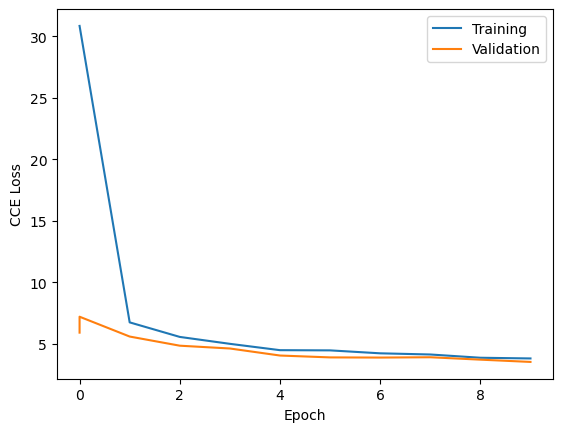

In [27]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

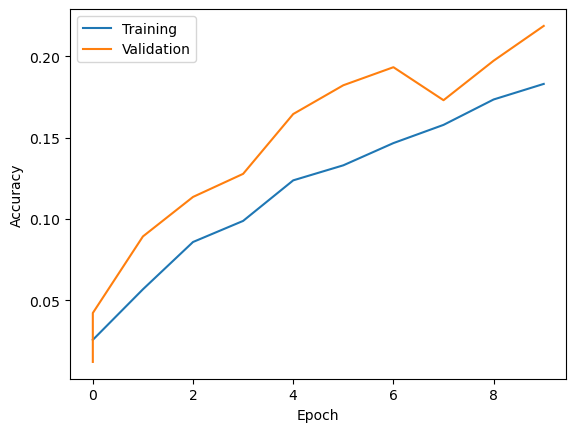

In [28]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [29]:
trainer.validate(model, xy_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.22210000455379486    │
│         val_loss          │    3.5076968669891357     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.22210000455379486, 'val_loss': 3.5076968669891357}]

### ResNet50

In [38]:
class ResNet50(pl.LightningModule):
    def __init__(self,
                 input_shape,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
        self.resnet = torchvision.models.resnet50(weights=None,
                                                  num_classes=output_size)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)
        y = self.resnet(y)
        #y = self.output_layer(y)       
        return y

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

In [39]:
model = ResNet50(x_train.shape[1:],
                 len(torch.unique(y_train)))

print(model)

ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

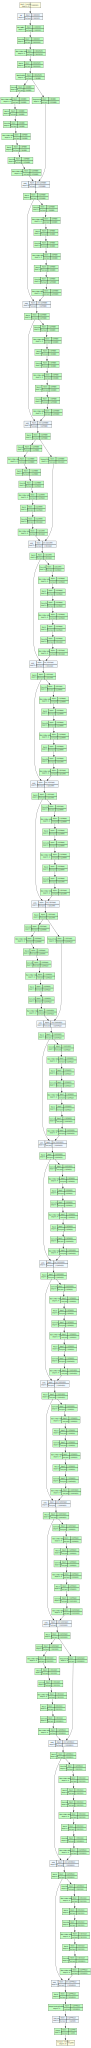

In [40]:
model_graph = draw_graph(model, input_size=(1,)+x_train.shape[1:], device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=4)
model_graph.visual_graph

In [41]:
summary(model, input_size=(1,)+x_train.shape[1:],
        depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet50                                      [1, 100]                  --
├─ResNet: 1-1                                 [1, 100]                  --
│    └─Conv2d: 2-1                            [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 16, 16]           128
│    └─ReLU: 2-3                              [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                         [1, 64, 8, 8]             --
│    └─Sequential: 2-5                        [1, 256, 8, 8]            --
│    │    └─Bottleneck: 3-1                   [1, 256, 8, 8]            --
│    │    │    └─Conv2d: 4-1                  [1, 64, 8, 8]             4,096
│    │    │    └─BatchNorm2d: 4-2             [1, 64, 8, 8]             128
│    │    │    └─ReLU: 4-3                    [1, 64, 8, 8]             --
│    │    │    └─Conv2d: 4-4                  [1, 64, 8, 8]             36,864
│    │  

In [42]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="Demo-2023-03-22",
                              version="demo-1")

In [43]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=10,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
trainer.validate(model, xy_test)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/Demo-2023-03-22/demo-1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.009999999776482582    │
│         val_loss          │     8.211264610290527     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.009999999776482582, 'val_loss': 8.211264610290527}]

In [45]:
trainer.fit(model, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 23.7 M
1 | mc_acc   | MulticlassAccuracy | 0     
2 | cce_loss | CrossEntropyLoss   | 0     
------------------------------------------------
23.7 M    Trainable params
0         Non-trainable params
23.7 M    Total params
94.852    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [46]:
results = pd.read_csv("lightning_logs/Demo-2023-03-22/demo-1/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.0100,8.211265,0,0,NaN,NaN
1,0.0260,4.855781,0,159,NaN,NaN
2,NaN,NaN,0,159,0.015325,4.730643
3,0.0484,4.331948,1,319,NaN,NaN
4,NaN,NaN,1,319,0.038200,4.486439
5,0.0727,4.158125,2,479,NaN,NaN
6,NaN,NaN,2,479,0.061575,4.211988
7,0.0973,3.985136,3,639,NaN,NaN
8,NaN,NaN,3,639,0.083775,4.036766
9,0.1057,3.933386,4,799,NaN,NaN


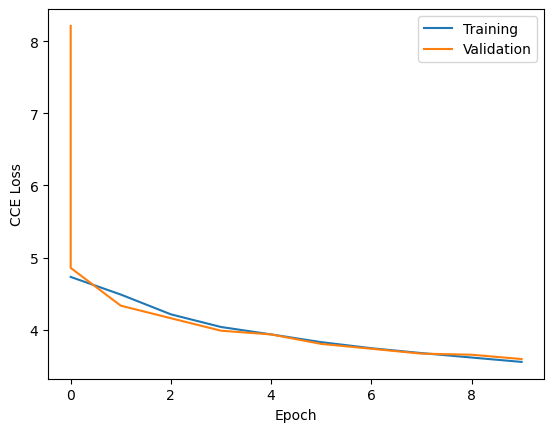

In [47]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

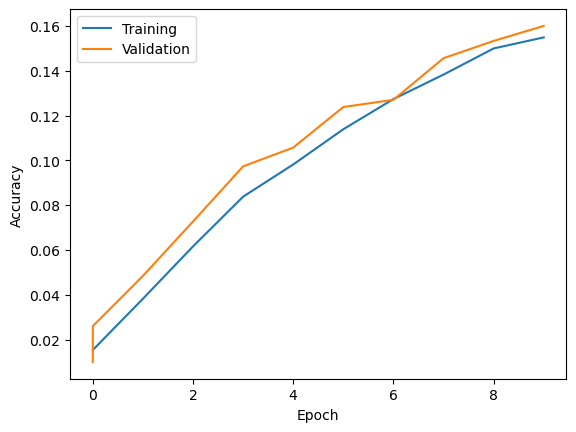

In [48]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [49]:
trainer.validate(model, xy_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.1607999950647354     │
│         val_loss          │    3.5732600688934326     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.1607999950647354, 'val_loss': 3.5732600688934326}]

### Transfer Learning Example
Note this is a little ill-posed because the models are optimized for 224x224 or greater resolution.

In [58]:
class ResNet50(pl.LightningModule):
    def __init__(self,
                 input_shape,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])
        self.resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

        # Modify Last Layer...
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, output_size)
        
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size)
        self.cce_loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        y = x
        y = self.normalize(y)
        if self.training:
            y = self.transform(y)
        y = self.resnet(y)
        return y

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.mc_acc(y_pred,y_true)
        loss = self.cce_loss(y_pred,y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

In [66]:
import os
os.environ["TORCH_HOME"] = os.environ["PWD"] + "/torch-data"

In [67]:
model = ResNet50(x_train.shape[1:],
                 len(torch.unique(y_train)))

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/jphillips/torch-data/hub/checkpoints/resnet50-11ad3fa6.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
  1%|          | 696k/97.8M [00:00<00:14, 7.12MB/s]
  9%|▉         | 8.98M/97.8M [00:00<00:01, 54.1MB/s]
 19%|█▊        | 18.1M/97.8M [00:00<00:01, 73.1MB/s]
 30%|██▉       | 29.1M/97.8M [00:00<00:00, 89.8MB/s]
 39%|███▊      | 37.7M/97.8M [00:00<00:01, 60.3MB/s]
 50%|████▉     | 48.6M/97.8M [00:00<00:00, 74.3MB/s]
 58%|█████▊    | 56.9M/97.8M [00:00<00:00, 68.6MB/s]
 66%|██████▌   | 64.2M/97.8M [00:01<00:00, 64.8MB/s]
 73%|███████▎  | 70.9M/97.8M [00:01<00:00, 54.1MB/s]
 84%|████████▍ | 81.9M/97.8M [00:01<00:00, 56.5MB/s]
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.3MB/s]


ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [68]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="Demo-2023-03-22",
                              version="demo-2")

In [69]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=10,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
trainer.validate(model, xy_test)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/Demo-2023-03-22/demo-2 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.008100000210106373    │
│         val_loss          │     4.958095550537109     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.008100000210106373, 'val_loss': 4.958095550537109}]

In [71]:
trainer.fit(model, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 23.7 M
1 | mc_acc   | MulticlassAccuracy | 0     
2 | cce_loss | CrossEntropyLoss   | 0     
------------------------------------------------
23.7 M    Trainable params
0         Non-trainable params
23.7 M    Total params
94.852    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [72]:
results = pd.read_csv("lightning_logs/Demo-2023-03-22/demo-2/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.0081,4.958096,0,0,NaN,NaN
1,0.0641,4.485235,0,159,NaN,NaN
2,NaN,NaN,0,159,0.026625,4.572965
3,0.1807,3.749191,1,319,NaN,NaN
4,NaN,NaN,1,319,0.112650,4.179227
5,0.2845,3.054566,2,479,NaN,NaN
6,NaN,NaN,2,479,0.225525,3.456085
7,0.3577,2.567647,3,639,NaN,NaN
8,NaN,NaN,3,639,0.312500,2.883673
9,0.4072,2.309195,4,799,NaN,NaN


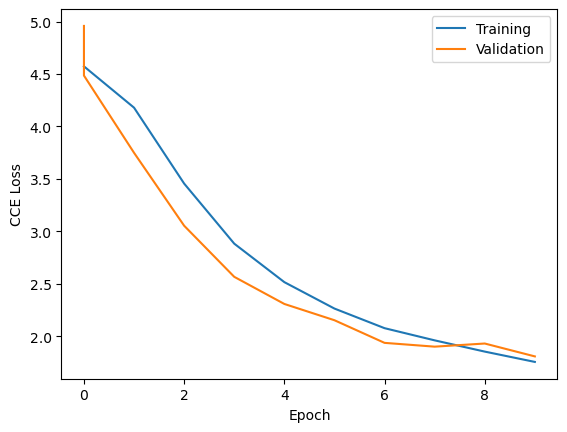

In [73]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

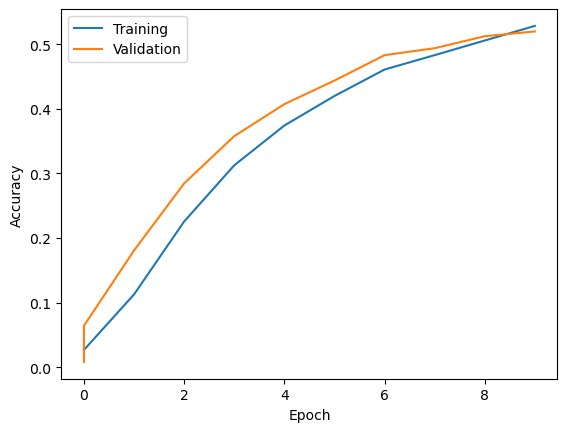

In [74]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [75]:
trainer.validate(model, xy_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5203999876976013     │
│         val_loss          │    1.8260544538497925     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.5203999876976013, 'val_loss': 1.8260544538497925}]